In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

import torch, config
from matplotlib import pyplot as plt
import numpy as np

from utils import plot_endmembers

plt.style.use('seaborn-v0_8')

/home/abian/Workspace/Anaconda/envs/CLHU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# An Informatic-Theoretical view on CLHU

$\begin{align}
\mathcal{I}(X; Z) + \lambda \mathcal{R}(Z)
\end{align}$

## Jasper Ridge dataset

In [2]:
from dataset import JasperRidge

dataset = JasperRidge(config.JasperRidge_PATH)
dataset_name = 'JasperRidge'
img_save_dir = os.path.join(config.IMG_PATH, 'JasperRidge')

From the dataset, separate a test subset, picking up the 32 samples with the highest 'abundance' value per endmember. Im total, the test subset is going to contain 128 samples.

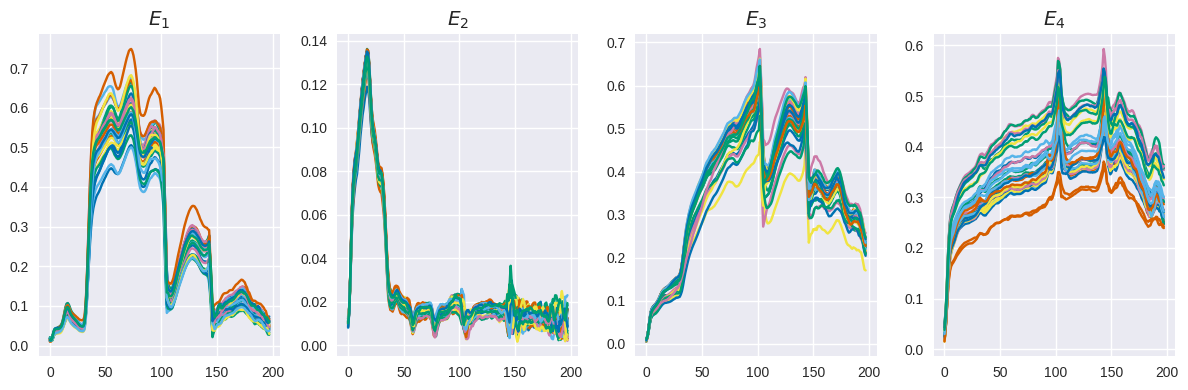

In [3]:
gt = dataset.abundance().permute(2,0,1)

#pick up the 32 first samples with the highest abundance per endmember
test_idx = torch.zeros(dataset.n_endmembers, 32, dtype=torch.long)
for i in range(dataset.n_endmembers):
    _, test_idx[i,:] = torch.topk(gt[i,:,:].flatten(), 32)

# sepparate train samples and test samples
train_idx = torch.ones_like(gt[0,:,:].flatten(), dtype=torch.bool)
train_idx[test_idx] = False
train_idx = torch.where(train_idx)[0]

# plot it
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(12,4))
    for i in range(dataset.n_endmembers):
        plt.subplot(1, 4, i+1)
        plt.plot(dataset[test_idx[i]].T)
        plt.title(f'$E_{i+1}$', fontsize='x-large')

    plt.tight_layout()
    plt.show()

In [4]:
# create a subset of the dataset
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx.flatten())

## CLHU Model
The CLHU model including the IPDL modules for IP estimation.

In [5]:
def define_Ax(X: torch.Tensor, gamma:float=.8) -> torch.Tensor:
    from functools import reduce
    from IPDL.functional import matrix_estimator

    n = X.size(0)
    d = X.size(1) if len(X.shape) == 2 else reduce(lambda x, y: x*y, X.shape[1:])
    sigma = gamma * n ** (-1 / (4+d)) * np.sqrt(d) 

    _, Ax = matrix_estimator(X, sigma=sigma)
    return Ax

In [6]:
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

from HySpecLab.unmixing.mixture import lmm
from HySpecLab.unmixing.utils import slide

from IPDL import MatrixEstimator
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as renyis


import torch 
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

class ContrastiveUnmixing(nn.Module):
    def __init__(self, n_bands, n_endmembers, encode_layers=[512, 128, 32], endmember_init=None) -> None:
        super(ContrastiveUnmixing, self).__init__()      
        encode_layers = [n_bands] + encode_layers
        
        # Encoder
        encoder = []
        for idx, test in enumerate(slide(encode_layers, 2)):
            encoder.append(self.__encode_layer(*test, dropout=True if idx < len(encode_layers)-2 else False))
        self.encoder = nn.Sequential(*encoder)

        # Endmember bank
        self.ebk = Parameter(torch.randn(n_endmembers, n_bands))
        if endmember_init is not None:
            self.ebk.data = endmember_init

        # Projection layer
        self.projection = nn.Sequential(
            nn.Linear(encode_layers[-1], n_bands, bias=False),
            MatrixEstimator(.1)
        )
        
        # Abundance matrix
        self.A = None
        self.A_matrix_estimator = MatrixEstimator(.1)
        self.matrix_estimator = MatrixEstimator(.1)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        r0 = self.projection( self.encoder(input) )

        self.A = self.A_matrix_estimator(self.__similarity(r0))
        out = lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))
        return self.matrix_estimator(out)
        # return lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))

    def __encode_layer(self, in_features, out_features, dropout=False):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            MatrixEstimator(.1),
            *[nn.ReLU(), nn.Dropout(0.5)] if dropout else [nn.Identity()]
        )

    def __similarity(self, X: torch.Tensor, temperature=1e-1) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.
                
                temperature: float, default=1e-1
                    temperature parameter for contrastive learning.
                
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(self.ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        return (1 - torch.pow(cos, 2))/temperature
    
    def mi_ze(self, gamma=1e-2):
        '''
            Compute the mutual information between the latent space and the endmembers.
            I(Z;E) = H(Z) - H(Z|E)
        '''
        z_p = self.projection[-1].x.to(self.ebk.device)
        z = self.encoder[-1][-2].x.cpu()
        Hz = renyis.entropy(define_Ax(z, gamma))
        # Hz = renyis.entropy(self.encoder[-1][-2].get_matrix())
        
        A = self.__similarity(z_p, temperature=1).detach().cpu()
        # A = softmax(self.__similarity(z_p).detach().cpu(), dim=1)
        HA = renyis.entropy(define_Ax(A, gamma))

        return Hz - HA
    

# class ContrastiveUnmixing(nn.Module):
#     def __init__(self, n_bands, n_endmembers, encode_layers=[512, 128, 32], endmember_init=None) -> None:
#         super(ContrastiveUnmixing, self).__init__()      
#         encode_layers = [n_bands] + encode_layers
        
#         # Encoder
#         encoder = []
#         for idx, test in enumerate(slide(encode_layers, 2)):
#             encoder.append(self.__encode_layer(*test, dropout=True if idx < len(encode_layers)-2 else False))
#         self.encoder = nn.Sequential(*encoder)

#         # Endmember bank
#         self.ebk = Parameter(torch.randn(n_endmembers, n_bands))
#         if endmember_init is not None:
#             self.ebk.data = endmember_init

#         # Projection layer
#         self.projection = nn.Linear(encode_layers[-1], n_bands, bias=False)
        
#         # Abundance matrix
#         self.A = None

#     def forward(self, input: torch.Tensor) -> torch.Tensor:
#         r0 = self.projection( self.encoder(input) )

#         self.A = self.__similarity(r0)
#         return lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))

#     def __encode_layer(self, in_features, out_features, dropout=False):
#         return nn.Sequential(
#             nn.Linear(in_features, out_features),
#             # nn.BatchNorm1d(out_features),
#             *[nn.ReLU(), nn.Dropout(0.5)] if dropout else [nn.Identity()]
#         )

#     def __similarity(self, X: torch.Tensor, temperature=1e-1) -> torch.Tensor:
#         '''
#             Cosine similarity between input and endmember bank.

#             Parameters
#             ----------
#                 x: torch.Tensor, shape=(batch_size, n_bands)
#                     input tensor.
                
#                 temperature: float, default=1e-1
#                     temperature parameter for contrastive learning.
                
#         '''
#         bs, n_bands = X.shape
#         X = normalize(X, dim=1)

#         normalize_ebk = normalize(self.ebk.detach(), dim=1).expand(bs, -1, -1)
#         cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
#         return (1 - torch.pow(cos, 2))/temperature



In [7]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from tqdm import tqdm
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader
from IPDL import AutoEncoderInformationPlane
from IPDL.optim import SilvermanOptimizer

def define_Ax(X: torch.Tensor, gamma:float=.8) -> torch.Tensor:
    from functools import reduce
    from IPDL.functional import matrix_estimator

    n = X.size(0)
    d = X.size(1) if len(X.shape) == 2 else reduce(lambda x, y: x*y, X.shape[1:])
    sigma = gamma * n ** (-1 / (4+d)) * np.sqrt(d) 

    _, Ax = matrix_estimator(X, sigma=sigma)
    return Ax

from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

# from HySpecLab.unmixing import ContrastiveUnmixing
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, train_dataset:Dataset, test_dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = UnmixingLoss()
    entropy_reg  = NormalizedEntropy(S=n_endmembers)    
    volume_reg = SimplexVolumeLoss(train_dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')
    vol_reg_norm = volume_reg(torch.sigmoid(model.ebk.detach()))


    dataloader = DataLoader(train_dataset, batch_size=int(len(train_dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    entropy_weight = 0
    simplex_weight = 5e-3
    similarity_weight = .5

    scaler = torch.cuda.amp.GradScaler()

    #IPDL
    matrix_optimizer = SilvermanOptimizer(model, gamma=1e-1, normalize_dim=True)
    ip = AutoEncoderInformationPlane(model)
    Ax = define_Ax(test_dataset[:], gamma=1e-1)

    Ize = np.zeros(n_epochs+1)
    with torch.no_grad():
        model.eval()
        x = test_dataset[:].to(device)
        y = model(x)
        Ize[0] = model.mi_ze(gamma=1e-1)

    for epoch in epoch_iterator:
        epoch_loss = 0.
        model.train()
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + entropy_weight*entropy_reg(model.A) + simplex_weight*(volume_reg(sigmoid(model.ebk))/vol_reg_norm) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        with torch.no_grad():
            model.eval()
            x = test_dataset[:].to(device)
            y = model(x)
            test_loss = criterion(y, x)
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)), vls="%.4f" % test_loss.item())

        if epoch == 0: # Solo necesario una vez
            matrix_optimizer.step()

        _, _ = ip.computeMutualInformation(Ax.to(device))
        Ize[epoch+1] = model.mi_ze(gamma=1e-2)

    return ip, Ize

## Endmember estimation for initialization

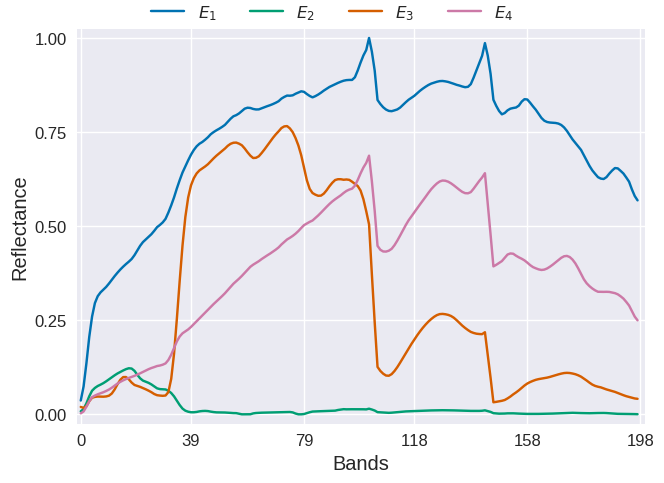

In [8]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers + 0
vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=42)

E = vca.fit(dataset.X.numpy())
endmember_init = torch.from_numpy(vca.endmembers()).float()
# endmember_init = (endmember_init / endmember_init.max(dim=1, keepdim=True)[0]) * .8

logit_endmember_init = torch.log((endmember_init + 1e-12) / ((1-endmember_init) + 1e-12))
# logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))
    

fig = plot_endmembers(endmember_init)
plt.show()

# fig.savefig(os.path.join(img_save_dir, 'CLHU_Endmembers_Init.pdf'))

## Training model

In [9]:
model = ContrastiveUnmixing(dataset.n_bands, n_endmembers, endmember_init=logit_endmember_init)
ip, Ize = train(model, n_endmembers, train_dataset, test_dataset, n_batchs=50, n_epochs=50, lr=1e-3)

100%|██████████| 50/50 [00:54<00:00,  1.10s/epoch, tls=0.0718, vls=0.0413]


In [10]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

_X = test_dataset[:]

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), 2*volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0413) tensor(0.5285) tensor(245.4505) tensor(0.3763)


In [11]:
volume_reg(endmember_init)*2, similarity_reg(endmember_init)

(tensor(403.2521), tensor(0.3818))

### Endmembers result

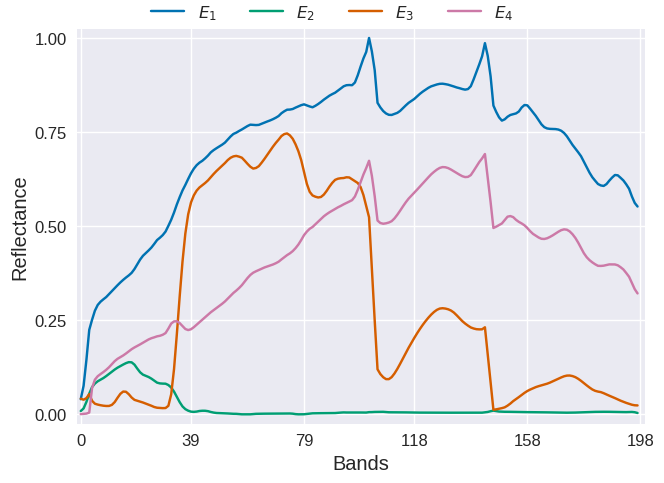

In [12]:
ebk = sigmoid(model.ebk.detach().cpu())
fig = plot_endmembers(ebk)
plt.show()

# fig.savefig(os.path.join(img_save_dir, 'CLHU_Endmembers.pdf'), bbox_inches='tight')

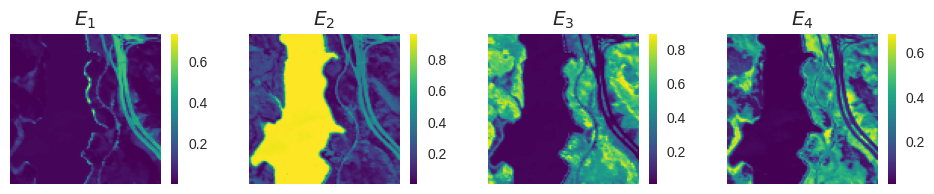

In [13]:
from torch.nn.functional import softmax
_ = model(dataset.X)

test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(100, 100, n_endmembers)
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))

fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(test[:,:,i].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

# fig.savefig(os.path.join(img_save_dir, 'CLHU_Abundance.png'), dpi=300, bbox_inches='tight')

## Information Plane estimation

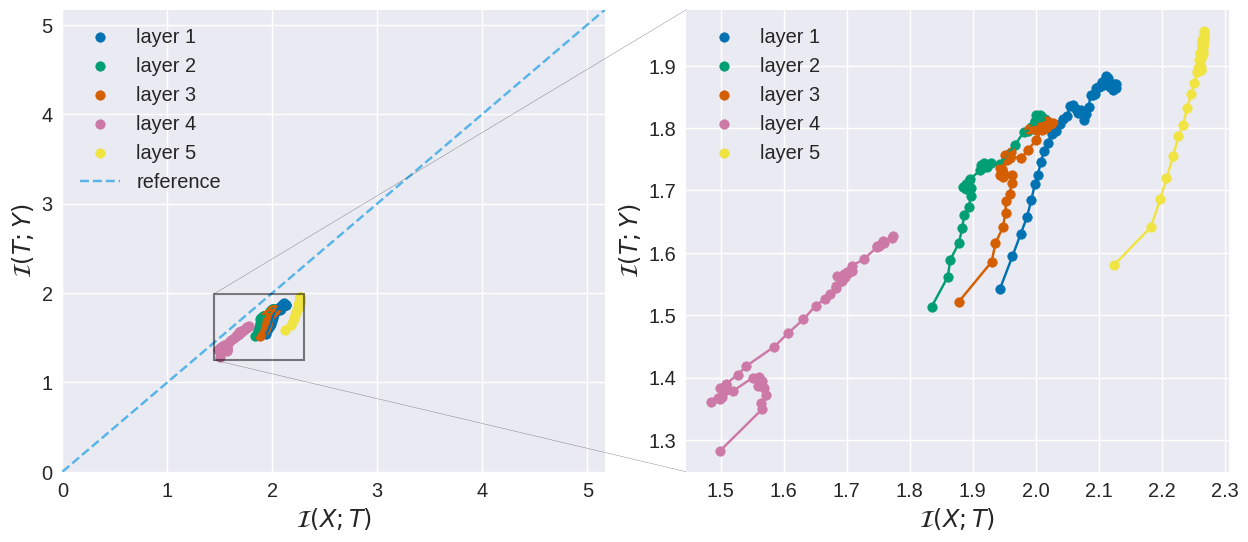

In [14]:
from IPDL import MatrixBasedRenyisEntropy

Ax = define_Ax(test_dataset[:], gamma=1e-2)

with plt.style.context('seaborn-colorblind'):
    fig, ax = plt.subplots(figsize=(7, 6))
    reference = MatrixBasedRenyisEntropy.entropy(Ax).cpu()
    ax.set(xlim=(0, reference), ylim=(0, reference))
    axins = ax.inset_axes([1.15, 0., 1, 1])

    Ixt, Ity = ip.getMutualInformation(moving_average_n=5)

    for idx, current_Ixt in enumerate(Ixt):
        current_Ity = Ity[idx]
        ax.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))
        ax.plot(current_Ixt, current_Ity)

        axins.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))
        axins.plot(current_Ixt, current_Ity)

    ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=1.5)
 
ax.set_xlabel("$\mathcal{I}(X;T)$", fontsize='xx-large')
ax.set_ylabel("$\mathcal{I}(T;Y)$", fontsize='xx-large')

axins.set_xlabel("$\mathcal{I}(X;T)$", fontsize='xx-large')
axins.set_ylabel("$\mathcal{I}(T;Y)$", fontsize='xx-large')
axins.legend(fontsize='x-large')

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', label='reference')
ax.legend(fontsize='x-large')

#ticks bigger
ax.tick_params(axis='both', which='major', labelsize='x-large')
axins.tick_params(axis='both', which='major', labelsize='x-large')

plt.show()

# fig.savefig(os.path.join(config.IMG_PATH, dataset_name,'CLHU_ip_end{}.pdf'.format(n_endmembers)), bbox_inches='tight')

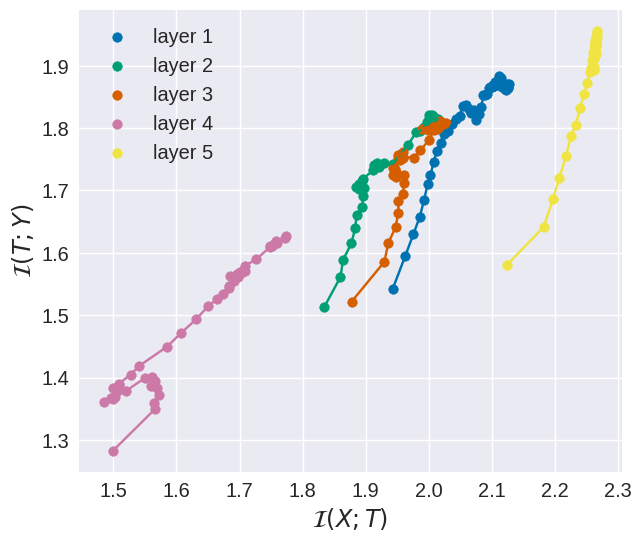

In [15]:
from IPDL import MatrixBasedRenyisEntropy

Ax = define_Ax(test_dataset[:], gamma=1e-2)

with plt.style.context('seaborn-colorblind'):
    fig, ax = plt.subplots(figsize=(7, 6))
    reference = MatrixBasedRenyisEntropy.entropy(Ax).cpu()

    Ixt, Ity = ip.getMutualInformation(moving_average_n=5)

    for idx, current_Ixt in enumerate(Ixt):
        current_Ity = Ity[idx]
        ax.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))
        ax.plot(current_Ixt, current_Ity)
 
ax.set_xlabel("$\mathcal{I}(X;T)$", fontsize='xx-large')
ax.set_ylabel("$\mathcal{I}(T;Y)$", fontsize='xx-large')
ax.legend(fontsize='x-large')

#ticks bigger
ax.tick_params(axis='both', which='major', labelsize='x-large')
axins.tick_params(axis='both', which='major', labelsize='x-large')

plt.show()

# fig.savefig(os.path.join(config.IMG_PATH, dataset_name,'CLHU_ip_end{}.pdf'.format(n_endmembers)), bbox_inches='tight')

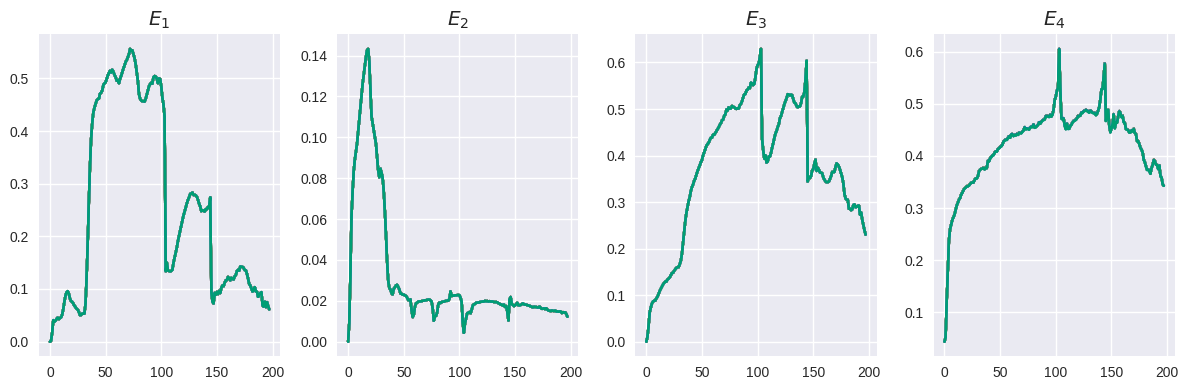

In [16]:
estimated_gt = dataset.A @ dataset.endmembers()

with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(12,4))
    for i in range(dataset.n_endmembers):
        plt.subplot(1, 4, i+1)
        plt.plot(estimated_gt[test_idx[i]].T)
        plt.title(f'$E_{i+1}$', fontsize='x-large')

    plt.tight_layout()
    plt.show()

estimated_gt_test = estimated_gt[test_idx.flatten()]
Agt = define_Ax(estimated_gt_test[:], gamma=1e-2)

In [17]:
renyis.entropy(Agt)

tensor(2.0012)

In [18]:
test_idx.flatten()

tensor([  59,    4,   38,   16,   26,   64,   39,   63,   52,    5,   15,   13,
          40,   17,   65,   35,   60,   10,   68,   11,   61,   12,   62,   27,
          41,    3,    6,   70,   67,   66,   53,   14, 2483, 2288, 2482, 1998,
        2388, 2486, 2194, 2582, 2285, 2484, 2095, 2195, 2494, 2086, 2495, 2099,
        2295, 2394, 2585, 2395, 2491, 2294, 2496, 1986, 2485, 2396, 2287, 2586,
        2584, 2583, 2488, 2193, 5406, 5505, 5608, 5506, 5607, 5705,   88, 5703,
        5605, 5609, 1128, 5403, 5711,  654, 5803,  188, 1599, 5307, 6570, 1034,
        5610, 5510, 5611, 5300, 5407, 5404, 5200, 6668, 5710, 5606, 5402,  592,
        8865, 7741, 9003, 7222, 7114, 8971, 7754, 8560, 8567, 8206, 8060, 8460,
        9072, 8870, 9203, 7845, 9173, 8257, 7856, 7702, 8864, 7958, 8668, 7949,
        8163, 7701, 8050, 7228, 7337, 8669, 7213, 7444])

In [19]:
test_idx.shape

torch.Size([4, 32])

In [20]:
ip.to_df()

Layer 1             Layer 2             Layer 3             Layer 4  \
         Ixt       Ity       Ixt       Ity       Ixt       Ity       Ixt   
0   1.889208  1.422550  1.726891  1.389505  1.664925  1.339967  1.175865   
1   1.927837  1.493124  1.857001  1.480529  1.907234  1.488087  1.558860   
2   1.948824  1.570696  1.832719  1.532955  1.900366  1.556380  1.529258   
3   1.967819  1.591358  1.870635  1.565254  1.955630  1.595899  1.619603   
4   1.979943  1.629880  1.886205  1.599651  1.960691  1.627982  1.612158   
5   1.989042  1.686353  1.853973  1.627830  1.925358  1.659868  1.511144   
6   1.994362  1.674230  1.877978  1.619238  1.937140  1.636482  1.546451   
7   1.998302  1.705156  1.898810  1.663641  1.958442  1.683457  1.568233   
8   2.003068  1.731265  1.899980  1.686873  1.977917  1.714483  1.607308   
9   2.007566  1.756281  1.898865  1.704779  1.961442  1.724477  1.561735   
10  2.011480  1.755225  1.895341  1.696546  1.958634  1.715574  1.542417   
11  2.018763  1.778464  1.889673  1.704121  1.950554  1.724527  1.523973   
12  2.025559  1.797709  1.900975  1.725510  1.958940  1.743196  1.517854   
13  2.031541  1.790352  1.861493  1.681892  1.913301  1.697390  1.454503   
14  2.036620  1.829285  1.873999  1.719137  1.932053  1.743660  1.456902   
15  2.043782  1.782914  1.923129  1.717522  1.983912  1.737638  1.558427   
16  2.050787  1.834403  1.909765  1.734942  1.946742  1.752597  1.491059   
17  2.054734  1.838932  1.910157  1.738784  1.943233  1.752367  1.461694   
18  2.059014  1.814621  1.940201  1.749904  1.992551  1.771374  1.570353   
19  2.064527  1.906317  1.904201  1.777164  1.933632  1.791718  1.460174   
20  2.066573  1.790440  1.903699  1.700900  1.938348  1.713415  1.513292   
21  2.072038  1.804479  1.927575  1.722649  1.951907  1.729439  1.538129   
22  2.075523  1.803036  1.933393  1.734404  1.958069  1.734949  1.554403   
23  2.080616  1.843874  1.975058  1.785022  2.012295  1.797881  1.637857   
24  2.084054  1.825758  1.977437  1.771797  2.025213  1.787867  1.681285   
25  2.088256  1.835737  1.954520  1.766839  1.987873  1.773129  1.621546   
26  2.089898  1.862671  1.996781  1.809702  2.017191  1.807209  1.660534   
27  2.092152  1.898350  1.998416  1.833730  2.003907  1.822603  1.650831   
28  2.094817  1.841916  2.008023  1.798245  2.029916  1.798447  1.709289   
29  2.100213  1.838055  2.002397  1.797863  2.028077  1.802559  1.725443   
30  2.100929  1.877658  1.996866  1.813744  2.002602  1.802910  1.666543   
31  2.101243  1.877408  1.983666  1.807639  1.996078  1.802618  1.665570   
32  2.101995  1.890808  2.002634  1.834266  2.009443  1.825865  1.691893   
33  2.103305  1.850110  2.009057  1.807177  2.029338  1.808489  1.738966   
34  2.105823  1.846153  2.028762  1.811066  2.054276  1.814404  1.781796   
35  2.107177  1.876070  1.981608  1.810720  1.961458  1.781679  1.632605   
36  2.108339  1.908631  2.008521  1.844781  1.978443  1.808364  1.658671   
37  2.110690  1.864712  1.985674  1.795197  1.974356  1.772495  1.664530   
38  2.113009  1.879864  2.033383  1.836914  2.031619  1.827639  1.740262   
39  2.119159  1.891098  1.994251  1.814243  1.997915  1.805962  1.724998   
40  2.120412  1.855137  2.007900  1.800210  2.025960  1.797025  1.751094   
41  2.122116  1.837243  2.011053  1.795287  2.022433  1.790415  1.752211   
42  2.123108  1.868336  2.023996  1.826144  2.036764  1.821595  1.771924   
43  2.123300  1.863125  2.018534  1.819559  2.028207  1.813830  1.758410   
44  2.124310  1.878238  2.007140  1.814878  2.020594  1.814356  1.763119   
45  2.125384  1.886540  1.980050  1.807446  1.972213  1.791558  1.695867   
46  2.125561  1.854766  2.001057  1.801998  2.032744  1.808459  1.801719   
47  2.127751  1.843151  1.981643  1.780227  2.004472  1.780351  1.761192   
48  2.128866  1.857745  2.026850  1.805082  2.054993  1.811455  1.835930   
49  2.129625  1.909920  2.014395  1.843299  2.028789  1.844457  1.772642   

               Layer 5            
         Ity     

### $\mathcal{I}(Z;E)$ evolution...

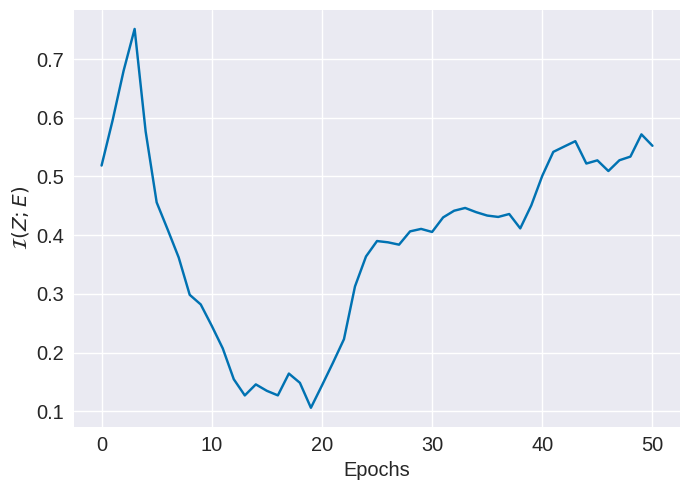

In [21]:
from utils import moving_average

Ize_average = moving_average(Ize.reshape(1,-1), n=5, padding_size=4) 
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(Ize_average.T)
    plt.xlabel('Epochs', fontsize='x-large')
    plt.ylabel('$\mathcal{I}(Z;E)$', fontsize='x-large')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.tight_layout()
    
plt.show()

# fig.savefig(os.path.join(img_save_dir, 'CLHU_Ize.pdf'), bbox_inches='tight')

# Testing

In [36]:
_ = model(test_dataset[:])

In [37]:
z_m = model.encoder[-1][-2].x.cpu()
model = model.cpu()
# z_m = model.encoder[-1][-2]

def similarity_loss(z_m, model, temperature=.5):

    X = model.projection(z_m)
    bs, n_bands = X.shape
    X = normalize(X, dim=1)

    normalize_ebk = normalize(model.ebk.detach(), dim=1).expand(bs, -1, -1)
    cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
    return (1 - torch.pow(cos, 2))/temperature

Abund = similarity_loss(z_m, model).detach()
AAbund = define_Ax(Abund, gamma=1e-2)

In [ ]:
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as renyis
Hz = renyis.entropy(model.encoder[-1][-2].get_matrix())
Hz_p = renyis.entropy(model.projection[-1].get_matrix())
# HA = renyis.entropy(AAbund)


# Izy = renyis.mutualInformation(AAbund, model.encoder[-1][-2].get_matrix())
# print(Izy)

In [ ]:
Ax = define_Ax(test_dataset[:], gamma=1e-2)
Az = model.encoder[-1][-2].get_matrix()

Ixz = renyis.mutualInformation(Ax, Az)
Ixz

Ixa = renyis.mutualInformation(Ax, AAbund)
print(Ixz, Ixa)

In [ ]:
Hx = renyis.entropy(Ax)
print(Hx)

Ha = renyis.entropy(AAbund)
print(Ha)

Hz = renyis.entropy(Az)
print(Hz)

In [ ]:
MI = Hz - Ha
print(Hz, Ha, MI)

In [ ]:
model.mi_ze()

In [ ]:
Hz_p = renyis.entropy(model.projection[-1].get_matrix())

MI = Hz_p - Ha 
print(Hz_p, Ha, MI)

In [ ]:
def mi_ze(self, gamma=1e-2):
        '''
            Compute the mutual information between the latent space and the endmembers.
            I(Z;E) = H(Z) - H(Z|E)
        '''
        z_p = self.projection[-1].x.to(self.ebk.device)
        z = self.encoder[-1][-2].x.cpu()
        Hz = renyis.entropy(define_Ax(z, gamma))
        # Hz = renyis.entropy(self.encoder[-1][-2].get_matrix())
        
        A = self.__similarity(z_p).detach().cpu()
        HA = renyis.entropy(define_Ax(A, gamma))

        return Hz - HA

In [ ]:
Az = model.encoder[-1][-2].get_matrix()
Abund = similarity_loss(z_m, model).detach()
AAbund = define_Ax(Abund, gamma=1e-2)

renyis.mutualInformation(Az, AAbund)

In [ ]:
A2 = model.encoder[1][-3].get_matrix()

renyis.entropy(A2), renyis.mutualInformation(Az, A2)

In [ ]:
renyis.entropy(AAbund), renyis.entropy(Az)